In [81]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline  
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

In [82]:
df = pd.read_csv("winequality-red.csv")

In [83]:
df.shape

(1599, 12)

In [84]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [85]:
# Find missing values
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<AxesSubplot:>

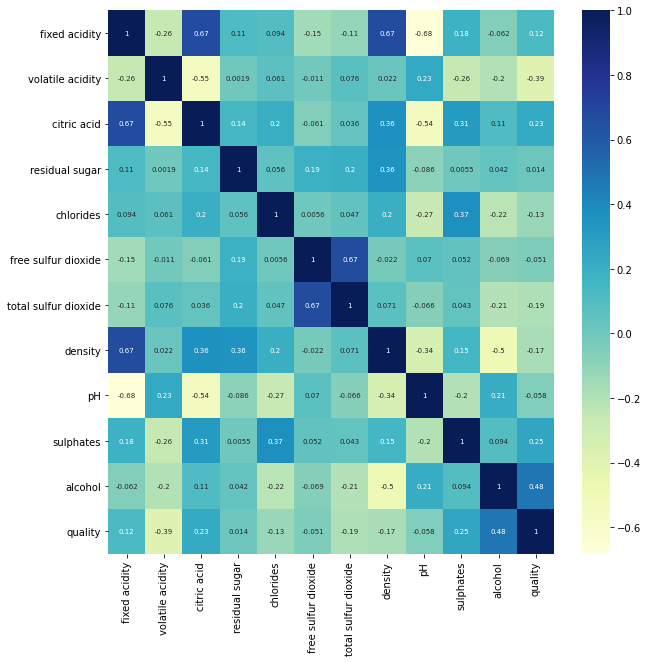

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 7}, cmap = "YlGnBu")

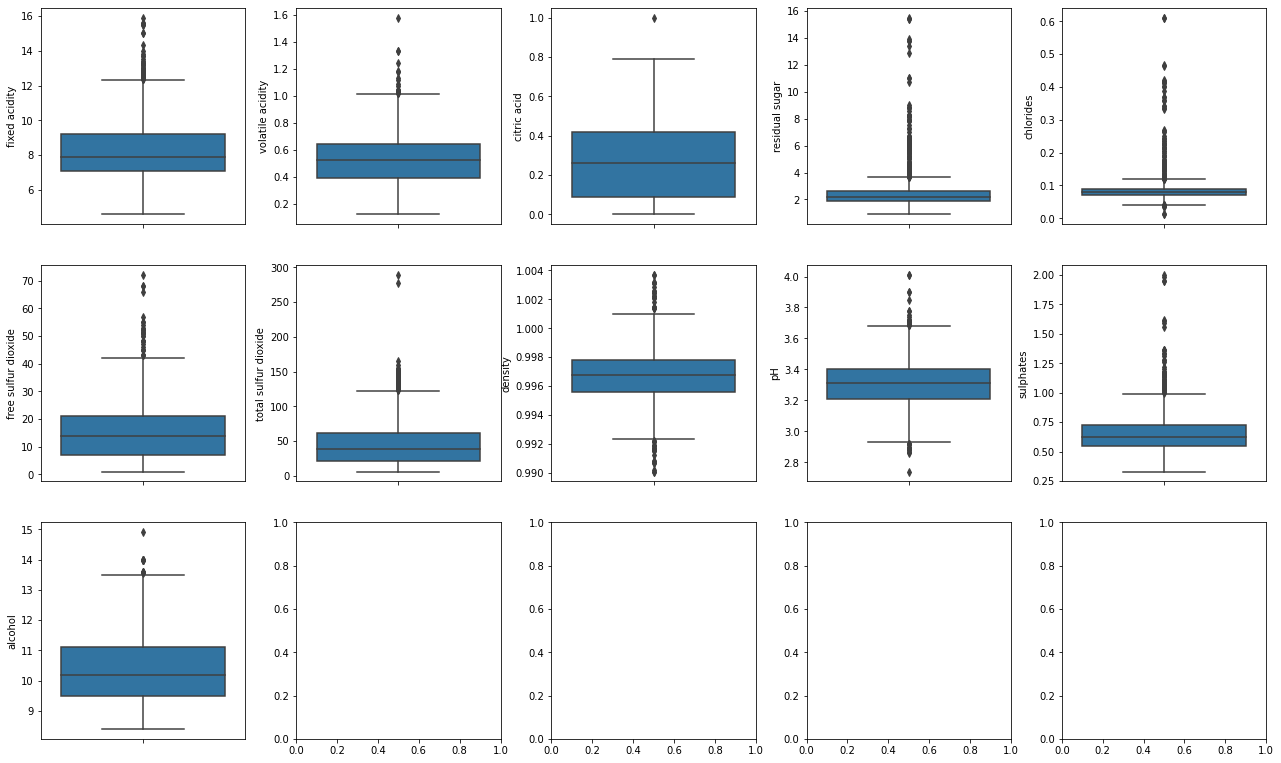

In [88]:
cols = list(df.iloc[:, :11])
fig, axes = plt.subplots(3, 5, figsize=(18, 11))
fig.tight_layout(pad=2.0)
for i in range(len(cols)):
    sns.boxplot(ax=axes[i//5, i%5], y=df[cols[i]])

We see that some of these features are skewed to the right with the presence of outliers.

<AxesSubplot:xlabel='quality', ylabel='count'>

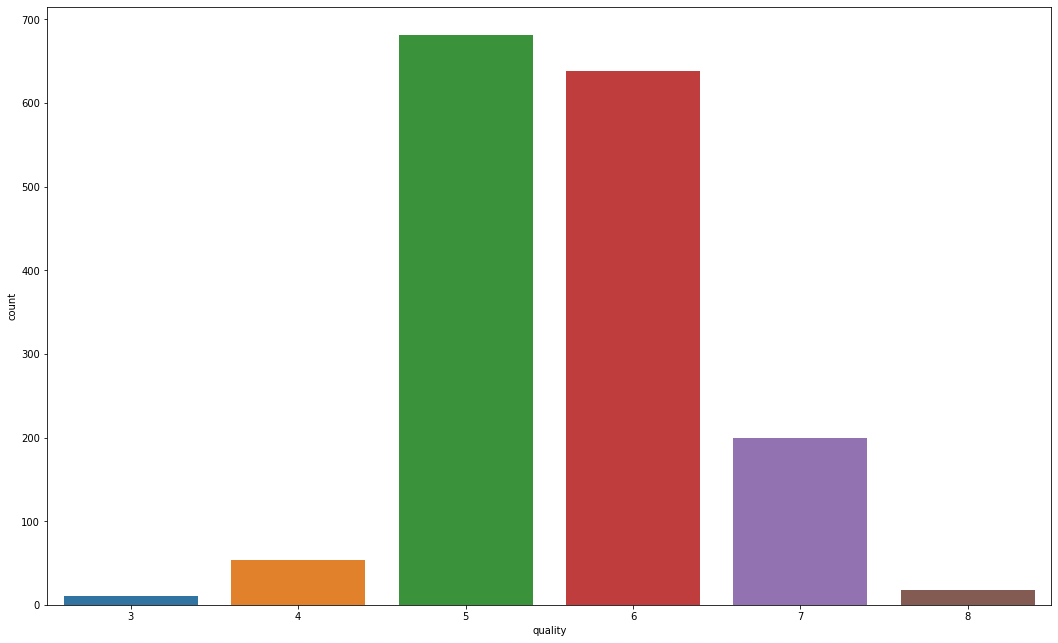

In [89]:
plt.figure(figsize=(18, 11))
sns.countplot(data=df, x = 'quality')

The dataset shows a very imbalanced distribution. Hence, I will combine quality of 3, 4, and 5 to low quality and quality of 6, 7, and 8 to high quality.

In [90]:
quality_dict = {3 : 'low',
                4 : 'low',
                5 : 'low',
                6 : 'low',
                7 : 'high',
                8 : 'high'}

In [91]:
df['quality'] = df['quality'].map(quality_dict)
df['quality'].head()

0    low
1    low
2    low
3    low
4    low
Name: quality, dtype: object

<AxesSubplot:xlabel='quality', ylabel='count'>

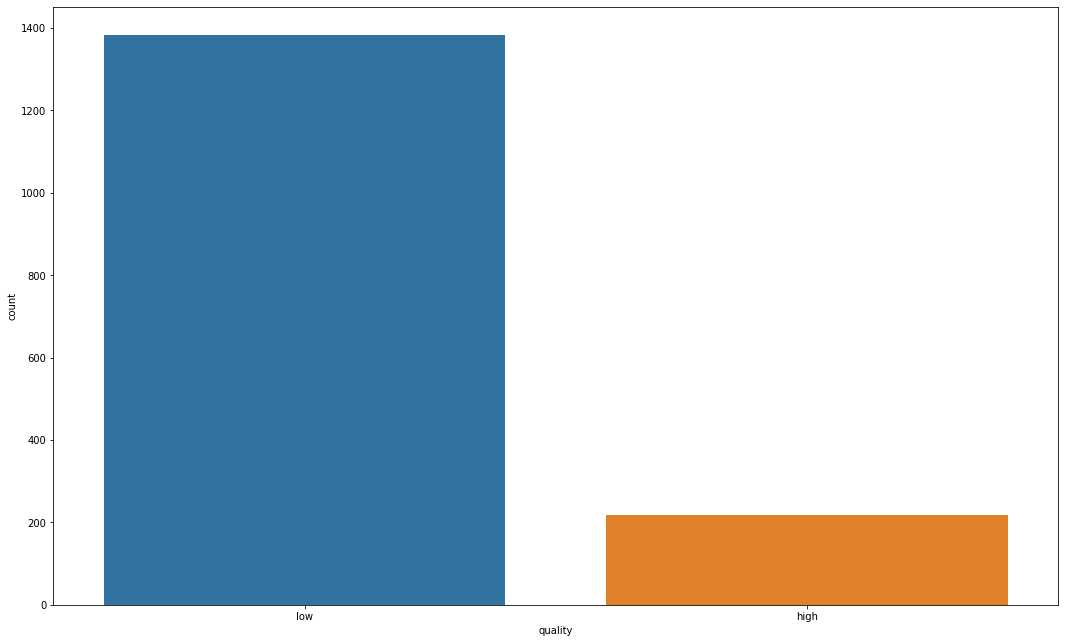

In [92]:
plt.figure(figsize=(18, 11))
sns.countplot(data=df, x = 'quality')

In [93]:
#Converts to binary classifiers
quality_label = LabelEncoder()
df['quality'] = quality_label.fit_transform(df['quality'])

In [94]:
quality = df['quality']
df.drop('quality', axis = 1, inplace = True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


# Normalization of skewed features

In [95]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(df)

PowerTransformer(standardize=False)

In [96]:
data = pt.transform(df)

In [97]:
transformed_df = pd.DataFrame(data, columns=df.columns)
transformed_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.965601,0.434520,-0.000000,0.434345,0.040250,2.715988,3.710526,0.057393,1.165072,0.206762,0.268966
1,0.972687,0.498508,-0.000000,0.454268,0.044648,3.662894,4.439253,0.057393,1.122948,0.217431,0.268972
2,0.972687,0.457142,0.038972,0.447288,0.043614,3.062287,4.205195,0.057393,1.131424,0.215122,0.268972
3,1.015099,0.224548,0.414036,0.434345,0.040006,3.206108,4.319267,0.057393,1.117205,0.208830,0.268972
4,0.965601,0.434520,-0.000000,0.434345,0.040250,2.715988,3.710526,0.057393,1.165072,0.206762,0.268966


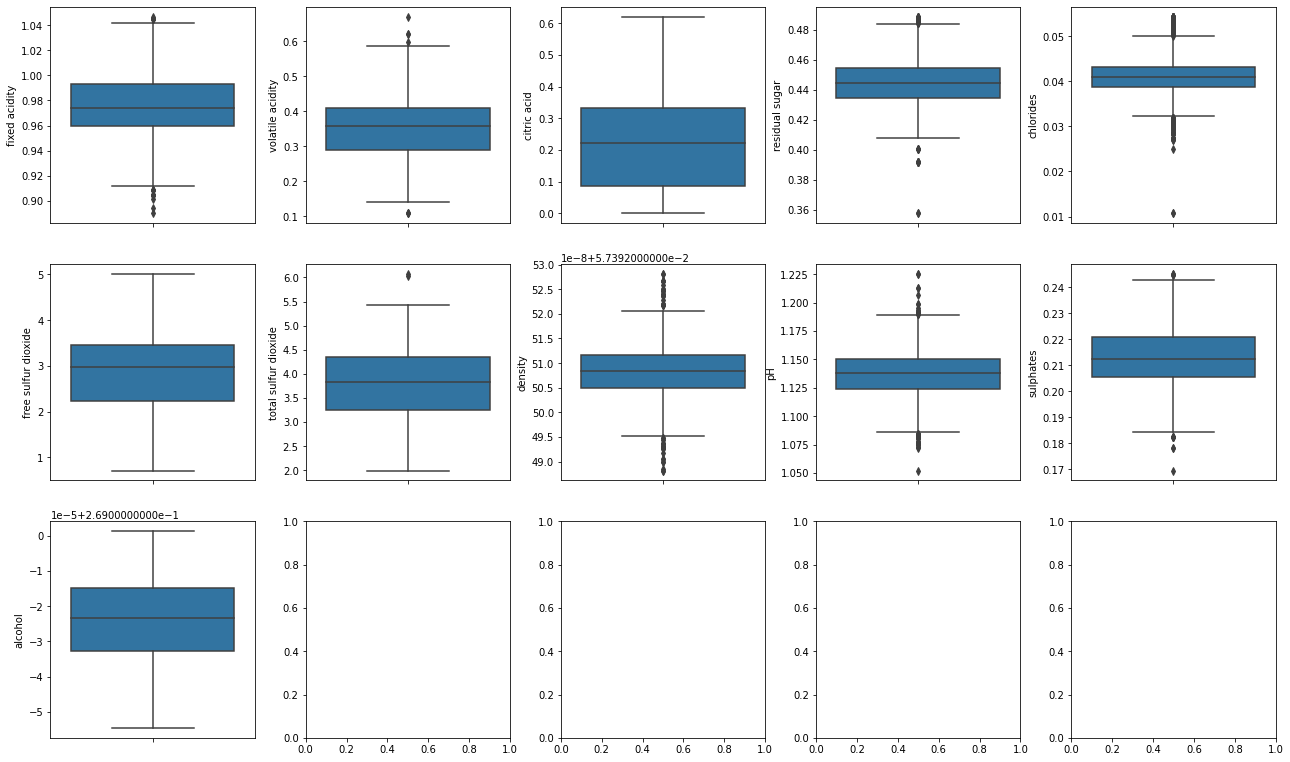

In [98]:
cols = list(transformed_df.iloc[:, :11])
fig, axes = plt.subplots(3, 5, figsize=(18, 11))
fig.tight_layout(pad=2.0)
for i in range(len(cols)):
    sns.boxplot(ax=axes[i//5, i%5], y=transformed_df[cols[i]])

In [99]:
sugar_outlier = transformed_df[transformed_df['residual sugar'] < 0.38].idxmin
sugar_outlier

<bound method DataFrame.idxmin of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1017       0.976009          0.155276     0.299237        0.357853   0.031823   
1018       0.976009          0.155276     0.299237        0.357853   0.031823   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
1017             4.112447              4.974241  0.057392  1.076378   
1018             4.112447              4.974241  0.057392  1.076378   

      sulphates   alcohol  
1017    0.19103  0.268994  
1018    0.19103  0.268994  >

In [100]:
chloride_outlier = transformed_df[transformed_df['chlorides'] < 0.02].idxmin
chloride_outlier

<bound method DataFrame.idxmin of      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
836       0.951547          0.224548     0.237214        0.449824   0.010711   
837       0.951547          0.224548     0.237214        0.449824   0.010711   

     free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
836             4.112447              4.878847  0.057392  1.131424   0.182297   
837             4.112447              4.878847  0.057392  1.131424   0.182297   

      alcohol  
836  0.268989  
837  0.268989  >

In [101]:
outllier_index = [836, 837, 1017, 1018]

In [102]:
no_outlier_df = transformed_df.copy()
#no_outlier_df.drop(outllier_index, inplace=True)

In [103]:
#quality.drop(outllier_index, inplace = True)

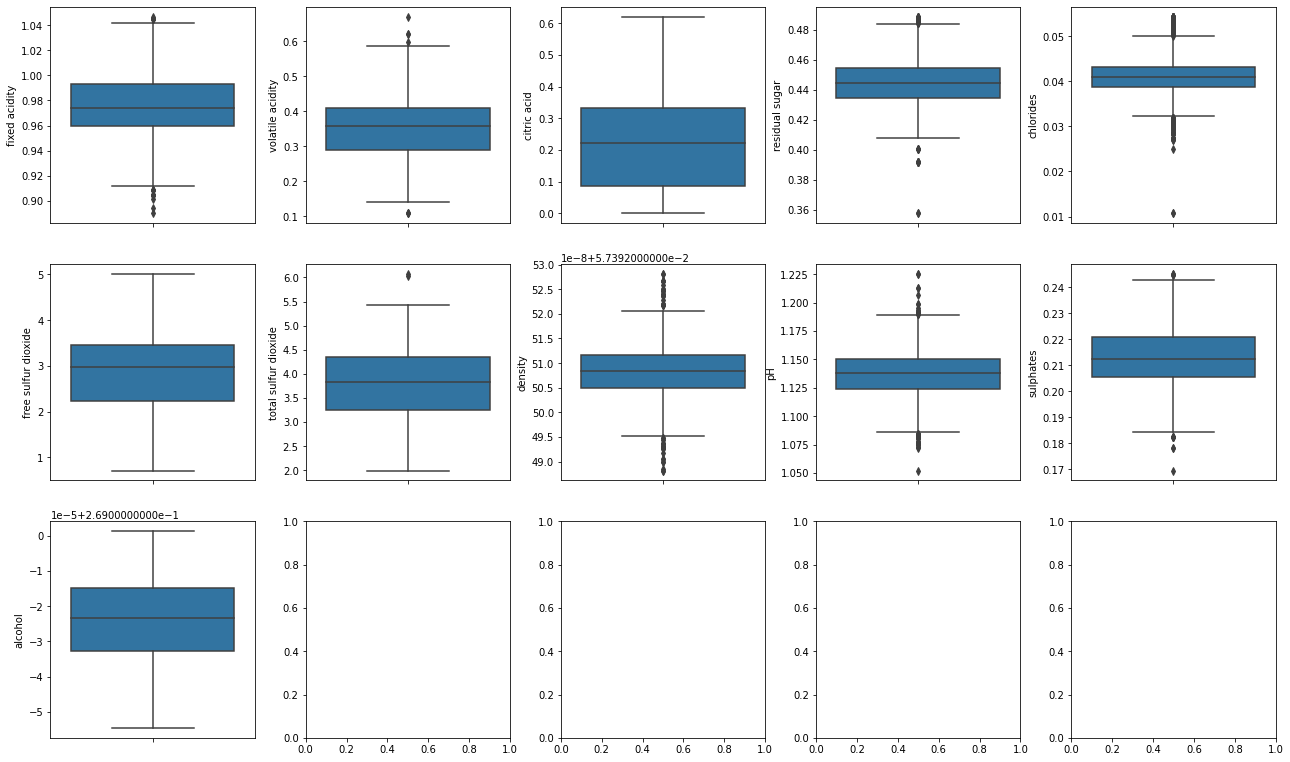

In [104]:
cols = list(no_outlier_df.iloc[:, :11])
fig, axes = plt.subplots(3, 5, figsize=(18, 11))
fig.tight_layout(pad=2.0)
for i in range(len(cols)):
    sns.boxplot(ax=axes[i//5, i%5], y=no_outlier_df[cols[i]])

In [105]:
robust_scaler = RobustScaler()
outlier_robust = robust_scaler.fit_transform(no_outlier_df)

In [106]:
scaled_no_outlier_df = pd.DataFrame(data = outlier_robust, columns = df.columns)

In [107]:
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))

In [108]:
# Test and Train set split
X_train, X_test, y_train, y_test = train_test_split(scaled_no_outlier_df, quality, random_state = 23, test_size = 0.2)

In [109]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
#X_train_over, y_train_over = X_train, y_train

C:\Users\redka\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='quality', ylabel='count'>

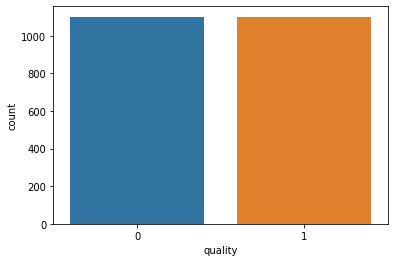

In [110]:
sns.countplot(y_train_over)

In [111]:
rf = RandomForestClassifier()
modeling(rf, X_train_over, X_test, y_train_over, y_test)

              precision    recall  f1-score   support

           0       0.57      0.65      0.60        40
           1       0.95      0.93      0.94       280

    accuracy                           0.89       320
   macro avg       0.76      0.79      0.77       320
weighted avg       0.90      0.89      0.90       320



In [112]:
svc = SVC()
modeling(svc, X_train_over, X_test, y_train_over, y_test)

              precision    recall  f1-score   support

           0       0.40      0.78      0.53        40
           1       0.96      0.84      0.89       280

    accuracy                           0.83       320
   macro avg       0.68      0.81      0.71       320
weighted avg       0.89      0.83      0.85       320



We see that the base model of Random Forest Classifier performs better than Support Vector Machine.

# Hyperparameter Tuning of Random Forest Classifier

In [113]:
param_grid = { 
    'n_estimators': [10, 30, 50, 100, 250, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [114]:
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
cv_rf.fit(X_train_over, y_train_over)

In [115]:
cv_rf.best_params_

In [116]:
rfc = RandomForestClassifier(criterion='gini', max_depth = 8, max_features = 'auto', n_estimators=500)
modeling(rfc, X_train_over, X_test, y_train_over, y_test)

              precision    recall  f1-score   support

           0       0.54      0.78      0.64        40
           1       0.97      0.91      0.94       280

    accuracy                           0.89       320
   macro avg       0.75      0.84      0.79       320
weighted avg       0.91      0.89      0.90       320



In [117]:
rfc.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=8, n_estimators=500)

In [118]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

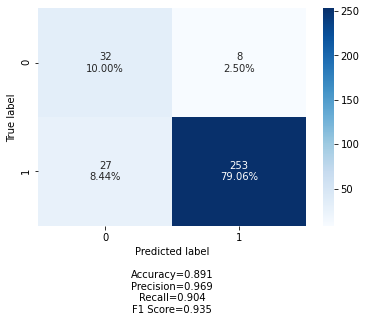

In [119]:
cf_matrix = confusion_matrix(y_test, rfc.predict(X_test))
make_confusion_matrix(cf_matrix, cmap='Blues')
